## 1. Class Define for GMV

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cufflinks as cf
cf.go_offline(connected=True)
from scipy import optimize 
from datetime import datetime
from dateutil.relativedelta import relativedelta
%matplotlib inline

try:
  import pandas_datareader.data as web
  import chart_studio as py
except:
  !pip install pip pandas-datareader
  !pip install chart_studio
  import pandas_datareader.data as web
  import chart_studio as py

In [7]:
class Asset():
  def __init__(self, ticker, name, start, end):
    self.ticker = ticker
    self.name = name
    
    self.start = start
    self.end = end

    # 데이터 불러오기
    self.data = web.get_data_yahoo(self.ticker, self.start, self.end)
    self.date = self.data.index

    self.ratio = 0
    self.leverage = 0
    self.price = None
    self.change = None

  def put_ratio_leverage(self, ratio, leverage):
    self.ratio = ratio
    self.leverage = leverage

  def put_price_change(self):
    self.price = self.data['Adj Close']
    self.change = np.multiply(self.price.pct_change().to_list(), [100 * self.leverage])

  def get_date(self):
    return self.date

  def get_change(self):
    return self.change

  def get_name(self):
    return self.name

In [8]:
#class Stock takes array of closing prices at the beginning and at the end of the year
#and calculates geometric return and standard deviation
#to simplify the calculation let's assume that there are no dividends
class Stock:
    def __init__(self, prices):
        self.prices = prices

    def annual_returns(self):
        returns = []
        for i in range(0, len(self.prices)-1):
            returns.append((self.prices[i+1]-self.prices[i])/self.prices[i])
        return(returns)
            
    def geometric_return(self, returns):
        return(np.prod([x+1 for x in returns])**(1/len(returns))-1)
    
    def standard_deviation(self, returns):
        mean = sum(returns)/len(returns)
        return(np.sqrt(sum([(x-mean)**2 for x in returns])/len(returns)))

In [50]:
class Portfolio():
  def __init__(self, name, assets, ratios, leverages, initial_balance, rebalancing_interval):
    self.name = name
    
    # list of class asset elements
    self.assets = assets

    # Assert all the dates for assets are equal and set portfolio start, end dates
    dates = [each.get_date() for each in self.assets]
    lendates = [len(each) for each in dates]
    assert len(set(lendates)) == 1
    self.date = dates[0]

    self.ratios = [each / sum(ratios) for each in ratios]
    self.leverages = leverages

    for i in range(len(self.assets)):
      self.assets[i].put_ratio_leverage(self.ratios[i], self.leverages[i])
      self.assets[i].put_price_change()

    self.initial_balance = initial_balance  
    self.rebalancing_interval = rebalancing_interval

    self.backtest_df = None
    self.backtest_result_df = None
    self.summary = None

  def backtest(self):
    # 첫 거래일
    balances = []
    for i in range(len(self.assets)):
      balance = [self.initial_balance * self.ratios[i]]
      balances.append(balance)
    
    total_balance = [self.initial_balance]
    next_rebalancing = [self.date[0] + relativedelta(months=self.rebalancing_interval)]

    # 이후 거래일
    for i in range(1, len(self.date)):
      total_balance_tmp = 0

      if self.date[i] >= next_rebalancing[i-1]: # 리밸런싱하는 날
        # 다음 리밸런싱 날짜 추가
        next_rebalancing.append(next_rebalancing[i-1] + relativedelta(months=self.rebalancing_interval))
        for j in range(len(self.assets)):
          balance = total_balance[i-1] * self.ratios[j] * (1 + self.assets[j].get_change()[i] / 100)
          balances[j].append(balance)
          total_balance_tmp += balances[j][i]
      else:
        # 이전 리밸런싱 날짜랑 동일하게
        next_rebalancing.append(next_rebalancing[i-1])
        for j in range(len(self.assets)):
          try:
            balances[j].append(balances[j][i-1] * (1 + self.assets[j].get_change()[i] / 100))
          except:
            balances[j].append(balances[j][i-1])
          total_balance_tmp += balances[j][i]

      total_balance.append(total_balance_tmp)

    df = pd.DataFrame()
    df['Date'] = self.date
    df.set_index('Date', inplace=True)
    df['Total'] = total_balance

    for i in range(len(self.assets)):
      df[self.assets[i].get_name()] = balances[i]
    
    print('Portfolio Backtest Complete')
    self.backtest_df = df

    return df

  def balance_result(self, balance):
    change = [0]
    cum_return = [0]
    prev_high = [0]
    prev_high_tmp = 0
    drawdown = [0]
    mdd = [0]
    mdd_tmp = 0
    CAGR = [0]
    stdev = [0]
    sharpe = [0]

    time_period = (self.date[-1] - self.date[0]).days / 365

    for i in range(1, len(self.date)):
      change.append((balance[i] / balance[i-1] - 1) * 100)
      cum_return.append((balance[i] / balance[0] - 1) * 100)

      if prev_high_tmp < cum_return[i]:
        prev_high_tmp = cum_return[i]
      else:
        prev_high_tmp = prev_high_tmp
      prev_high.append(prev_high_tmp)

      CAGR.append(((balance[i] / balance[0]) ** (1 / float(time_period)) - 1) * 100)

      drawdown.append(((cum_return[i] + 100) / (prev_high[i] + 100) - 1) * 100)

      if mdd_tmp > drawdown[i]:
        mdd_tmp = drawdown[i]
      else:
        mdd_tmp = mdd_tmp
      mdd.append(mdd_tmp)

      stdev.append(np.std(change))
      if stdev[i] != 0:
        sharpe.append(np.sqrt(252) * np.mean(change) / np.std(change))
      else:
        sharpe.append(0)

    return change, cum_return, prev_high, CAGR, drawdown, mdd, stdev, sharpe

  def backtest_result(self):
    df = pd.DataFrame()
    df['Date'] = self.date
    df.set_index('Date', inplace=True)
    label = ['Change', 'Cum. Return', 'Prev. High', 'CAGR', 'Drawdown', 'MDD', 'St. Dev', 'Sharpe']

    result = dict()
    for i in self.backtest_df.columns:
      result[i] = self.balance_result(self.backtest_df[i].to_list())
      df[f'{i} Balance'] = self.backtest_df[i].to_list()
      print(f'{i} Complete')

    for j in range(len(label)):
      print("EUM1 :", label[j])
      for i in self.backtest_df.columns:
        print("EUM2 :", i)
        print("EUM3 :", len(result[i][j]))
        df[f'{i} {label[j]}'] = result[i][j]

    self.backtest_result_df = df

    return df
  
  def periodic_result(self, mode):
    df = pd.DataFrame()

    for label in self.backtest_df.columns:
      return_points = []
      returns = []
      start_balance = []
      end_balance = []
      start = self.backtest_df[label].to_list()[0]
      
      if mode == 'annual':
        for i in range(1, len(self.date)):
          if self.date[i].year != self.date[i-1].year:
            return_points.append(self.date[i-1].year)
            returns.append((self.backtest_df[label].to_list()[i-1] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
            start = self.backtest_df[label].to_list()[i]
          elif self.date[i] == self.date[-1]: # 마지막 거래일
            return_points.append(self.date[i].year)
            returns.append((self.backtest_df[label].to_list()[i] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
        df[f'{label} {mode.capitalize()} Return'] = returns
        
      elif mode == 'monthly':
        for i in range(1, len(self.date)):
          if self.date[i].month != self.date[i-1].month:
            return_points.append(self.date[i-1].strftime('%Y-%m'))
            returns.append((self.backtest_df[label].to_list()[i-1] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
            start = self.backtest_df[label].to_list()[i]
          elif self.date[i] == self.date[-1]: # 마지막 거래일
            return_points.append(self.date[i].strftime('%Y-%m'))
            returns.append((self.backtest_df[label].to_list()[i] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
        df[f'{label} {mode.capitalize()} Return'] = returns

    df[f'Return {mode.capitalize()}'] = return_points
    df.set_index(f'Return {mode.capitalize()}', inplace=True)

    print(f'{mode.capitalize()} Result Complete')

    return df

  def get_name(self):
    return self.name

  def get_date(self):
    return self.date

  def get_backtest_result(self):
    return self.backtest_result_df

  def get_summary(self):
    # columns=['Detail', 'Initial Balance', 'Final Balance', 'CAGR', 'MDD', 'St. Dev', 'Sharpe Ratio']
    
    detail = ''
    for i in range(len(self.assets)):
      name = self.assets[i].get_name()
      percentage = int(self.ratios[i] * 100)

      detail += f'{name} ({percentage}%, {self.leverages[i]}x) '

    self.summary = [detail, self.backtest_result_df['Total Balance'][0], self.backtest_result_df['Total Balance'][-1],
                    str(round(self.backtest_result_df['Total CAGR'][-1], 2))+'%', str(round(self.backtest_result_df['Total MDD'][-1], 2))+'%',
                    round(self.backtest_result_df['Total St. Dev'][-1], 2), round(self.backtest_result_df['Total Sharpe'][-1], 2)]
    
    return self.summary

In [10]:
#@title
class Visualize():
  def __init__(self, portfolios):
    self.portfolios = portfolios

     # Assert all the dates for assets are equal and set portfolio start, end dates
    dates = [each.get_date() for each in self.portfolios]
    lendates = [len(each) for each in dates]
    assert len(set(lendates)) == 1
    self.date = dates[0]

  def line_plot(self, result, title, return_type):
#     for i in range(len(self.portfolios)):
#       plt.plot(self.date, self.portfolios[i].get_backtest_result().loc[:, f'Total {result}'], label=self.portfolios[i].get_name())
    
#     plt.title(title)
#     plt.legend(loc='best')
#     plt.yscale(return_type)
#     plt.show()
    
    data_list = []
    colm_list = []
    for i in range(len(self.portfolios)):
        data_list.append(self.portfolios[i].get_backtest_result().loc[:, f'Total {result}'])
        colm_list.append(self.portfolios[i].get_name())
    plot_df = pd.DataFrame(data_list).T
    plot_df.columns = colm_list
    plot_df.iplot(kind='line')
    
    
    
  def bar_plot(self, title, period):
#     for i in range(len(self.portfolios)):
#       if period == 'annual':
#         result = self.portfolios[i].periodic_result('annual')
#         plt.bar(result.index, result.loc[:, 'Total Annual Return'], label=self.portfolios[i].get_name())
#       elif period == 'monthly':
#         result = self.portfolios[i].periodic_result('monthly')
#         plt.bar(result.index, result.loc[:, 'Total Monthly Return'], label=self.portfolios[i].get_name())
    
#     plt.title(title)
#     plt.legend(loc='best')
#     plt.show()
    
    data_list = []
    colm_list = []
    for i in range(len(self.portfolios)):
      if period == 'annual':
        data_list.append(self.portfolios[i].periodic_result('annual').loc[:, 'Total Annual Return'])
        colm_list.append(self.portfolios[i].get_name())
      elif period == 'monthly':
        data_list.append(self.portfolios[i].periodic_result('monthly').loc[:, 'Total Monthly Return'])
        colm_list.append(self.portfolios[i].get_name())
    
    plot_df = pd.DataFrame(data_list).T
    plot_df.columns = colm_list
#     plot_df.plot.bar()
    plot_df.iplot(kind='bar', barmode='stack')

In [11]:
#@title
#class portfolio takes matrix of returns for every stock, and array of their weights
class GMVPortfolio:
    def __init__(self, returns):
        self.returns = returns
    
    def portfolio_return(self, weights):
        geo_returns = []
        for i in range(0, len(self.returns)):        
            geo_returns.append(np.prod([x+1 for x in self.returns[i]])**(1/len(self.returns[i]))-1)
        return(sum([a*b for a,b in zip(weights, geo_returns)]))
        #return(geo_returns)

    def portfolio_volatility(self, weights):
        sd_values = []
        for i in self.returns:
            mean = sum(i)/len(i)
            sd_values.append(np.sqrt(sum([(x-mean)**2 for x in i])/len(i)))
        weighted_average = [a*b for a,b in zip(weights, sd_values)]
        corr = np.corrcoef(self.returns)
        values = []
        for j in range(0, len(weighted_average)):
            values.append(sum([weighted_average[j]*weighted_average[x]*corr[j,x] for x in range(0,len(weighted_average))]))
        return(np.sqrt(sum(values)))
        #return(values)

    def optimal_portfolio(self, desired_return):
        bounds = ((0.0, 1.0),) * len(self.returns)
        init = list(np.random.dirichlet(np.ones(len(self.returns)), size= 1)[0])
        optimal_weights = optimize.minimize(self.portfolio_volatility, init, method='SLSQP',
            constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)},
            {'type': 'eq', 'fun': lambda inputs: desired_return - self.portfolio_return(weights=inputs)}), bounds = bounds)
        return optimal_weights.x

## 2. Stock Data Load & EDA

In [ ]:
#@title
# stocks_to_portfolio = ['AMZN', 'AAPL', 'GOOGL', 'FB']
stocks_to_portfolio = ['AMZN', 'AAPL', 'GOOGL', 'SBUX', 'SO', 'INTC', 'CSCO', 'MET']
df = pd.DataFrame(columns=stocks_to_portfolio)
for i in stocks_to_portfolio:
    asset = Asset(i, "Asset " + str(i), '2016-01-01', '2020-10-31')
    df[i] = asset.data["Adj Close"]
    
    if i == stocks_to_portfolio[0]:
        df['date'] = asset.data.index
        df.set_index('date', inplace=True)

Text(0, 0.5, 'price in $')

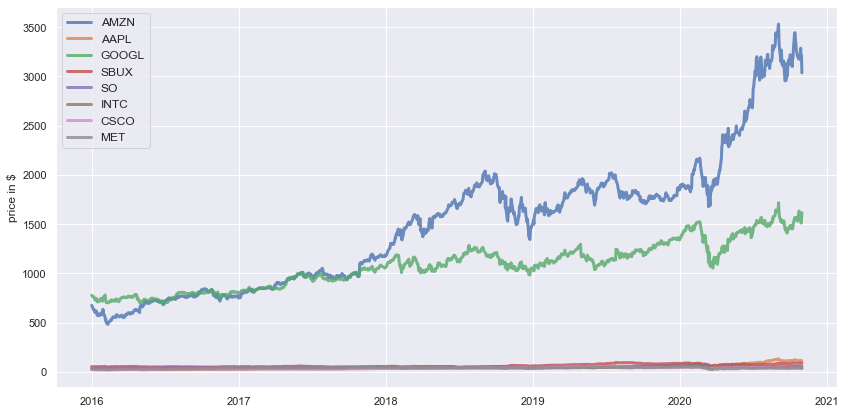

In [ ]:
#@title
sns.set_theme()
plt.figure(figsize=(14, 7))
for c in df.columns.values:
    plt.plot(df.index, df[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

## 3. Calculate GMV by Creating Random Weights

In [ ]:
#@title
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(mean_returns.shape[0])
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [ ]:
#@title
returns = df.pct_change()      # Daily return value of the stocks
mean_returns = returns.mean()  # Mean return value of the stocks
cov_matrix = returns.cov()     # Covariance of the stocks
num_portfolios = 25000         # Generate random 25000 portfolios
risk_free_rate = 0.0178        # 52 week treasury bill rates at the start of 2018

In [ ]:
#@title
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [ ]:
#@title
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

## 4. Calculate GMV by Optimizer

In [ ]:
#@title
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = optimize.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [ ]:
#@title
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = optimize.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [ ]:
#@title
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = optimize.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [ ]:
#@title
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [ ]:
#@title
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [ ]:
#@title
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(df.columns):
        print(txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(df.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

In [ ]:
#@title
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

## 60/40 Portfolio

In [51]:
asset1 = Asset('^IXIC', 'Asset 1', '2016-01-01', '2020-10-31')
asset2 = Asset('VUSTX', 'Asset 2', '2016-01-01', '2020-10-31')

sixty_forty_portfolio = Portfolio('60/40', [asset1, asset2], [6, 4], [1, 1], 1000, 3)
sixty_forty_backtest_df = sixty_forty_portfolio.backtest()
sixty_forty_backtest_result_df = sixty_forty_portfolio.backtest_result()
sixty_forty_annual_return_df = sixty_forty_portfolio.periodic_result('annual')
sixty_forty_monthly_return_df = sixty_forty_portfolio.periodic_result('monthly')
sixty_forty_summary = sixty_forty_portfolio.get_summary()

Portfolio Backtest Complete
Total Complete
Asset 1 Complete
Asset 2 Complete
EUM1 : Change
EUM2 : Total
EUM3 : 1217
EUM2 : Asset 1
EUM3 : 1217
EUM2 : Asset 2
EUM3 : 1217
EUM1 : Cum. Return
EUM2 : Total
EUM3 : 1217
EUM2 : Asset 1
EUM3 : 1217
EUM2 : Asset 2
EUM3 : 1217
EUM1 : Prev. High
EUM2 : Total
EUM3 : 1217
EUM2 : Asset 1
EUM3 : 1217
EUM2 : Asset 2
EUM3 : 1217
EUM1 : CAGR
EUM2 : Total
EUM3 : 1217
EUM2 : Asset 1
EUM3 : 1217
EUM2 : Asset 2
EUM3 : 1217
EUM1 : Drawdown
EUM2 : Total
EUM3 : 1217
EUM2 : Asset 1
EUM3 : 1217
EUM2 : Asset 2
EUM3 : 1217
EUM1 : MDD
EUM2 : Total
EUM3 : 1217
EUM2 : Asset 1
EUM3 : 1217
EUM2 : Asset 2
EUM3 : 1217
EUM1 : St. Dev
EUM2 : Total
EUM3 : 1217
EUM2 : Asset 1
EUM3 : 1217
EUM2 : Asset 2
EUM3 : 1217
EUM1 : Sharpe
EUM2 : Total
EUM3 : 1217
EUM2 : Asset 1
EUM3 : 1217
EUM2 : Asset 2
EUM3 : 1217
Annual Result Complete
Monthly Result Complete


In [28]:
asset1.date

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22',
               '2020-10-23', '2020-10-26', '2020-10-27', '2020-10-28',
               '2020-10-29', '2020-10-30'],
              dtype='datetime64[ns]', name='Date', length=1217, freq=None)

In [ ]:
sixty_forty_summary

['Asset 1 (60%, 1x) Asset 2 (40%, 1x) ',
 1000.0,
 1943.2611274026767,
 '14.73%',
 '-17.18%',
 0.73,
 1.24]

## All Weather Portfolio

In [31]:
asset3 = Asset('VTI', 'Asset 3', '2016-01-01', '2020-10-31')
asset4 = Asset('EDV', 'Asset 4', '2016-01-01', '2020-10-31')
asset5 = Asset('IEI', 'Asset 5', '2016-01-01', '2020-10-31')
asset6 = Asset('GLD', 'Asset 6', '2016-01-01', '2020-10-31')
asset7 = Asset('GSG', 'Asset 7', '2016-01-01', '2020-10-31')

awf_portfolio = Portfolio('All Weather', [asset3, asset4, asset5, asset6, asset7], [3, 4, 1.5, 0.75, 0.75], [1, 1, 1, 1, 1], 1000, 12)
awf_backtest_df = awf_portfolio.backtest()
awf_backtest_result_df = awf_portfolio.backtest_result()
awf_annual_return_df = awf_portfolio.periodic_result('annual')
awf_monthly_return_df = awf_portfolio.periodic_result('monthly')
awf_summary = awf_portfolio.get_summary()

Portfolio Backtest Complete
Total Complete
Asset 3 Complete
Asset 4 Complete
Asset 5 Complete
Asset 6 Complete
Asset 7 Complete
EUM1 : (1217, 6)


AttributeError: ignored

In [ ]:
awf_summary

['Asset 3 (30%, 1x) Asset 4 (40%, 1x) Asset 5 (15%, 1x) Asset 6 (7%, 1x) Asset 7 (7%, 1x) ',
 1000.0,
 1527.8005806352573,
 '9.16%',
 '-14.58%',
 0.52,
 1.1]

## Visualization

In [ ]:
aw_64 = Visualize([gmv_portfolio, sixty_forty_portfolio, awf_portfolio])

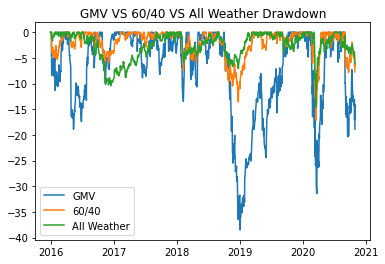

In [ ]:
aw_64.line_plot('Drawdown', 'GMV VS 60/40 VS All Weather Drawdown', 'linear')

Monthly Result Complete
Monthly Result Complete
Monthly Result Complete


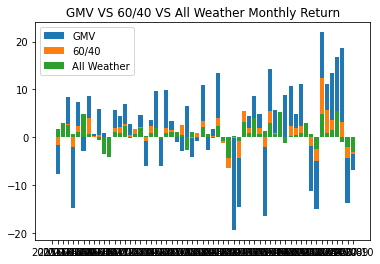

In [ ]:
aw_64.bar_plot('GMV VS 60/40 VS All Weather Monthly Return', 'monthly')